In [1]:
!pip install pafy youtube-dl moviepy

     |████████████████████████████████| 1.9 MB 8.7 MB/s 


In [ ]:
!pip uninstall -y pafy
!pip install git+https://github.com/Cupcakus/pafy

In [1]:
import os 
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical, plot_model 

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
%%capture
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

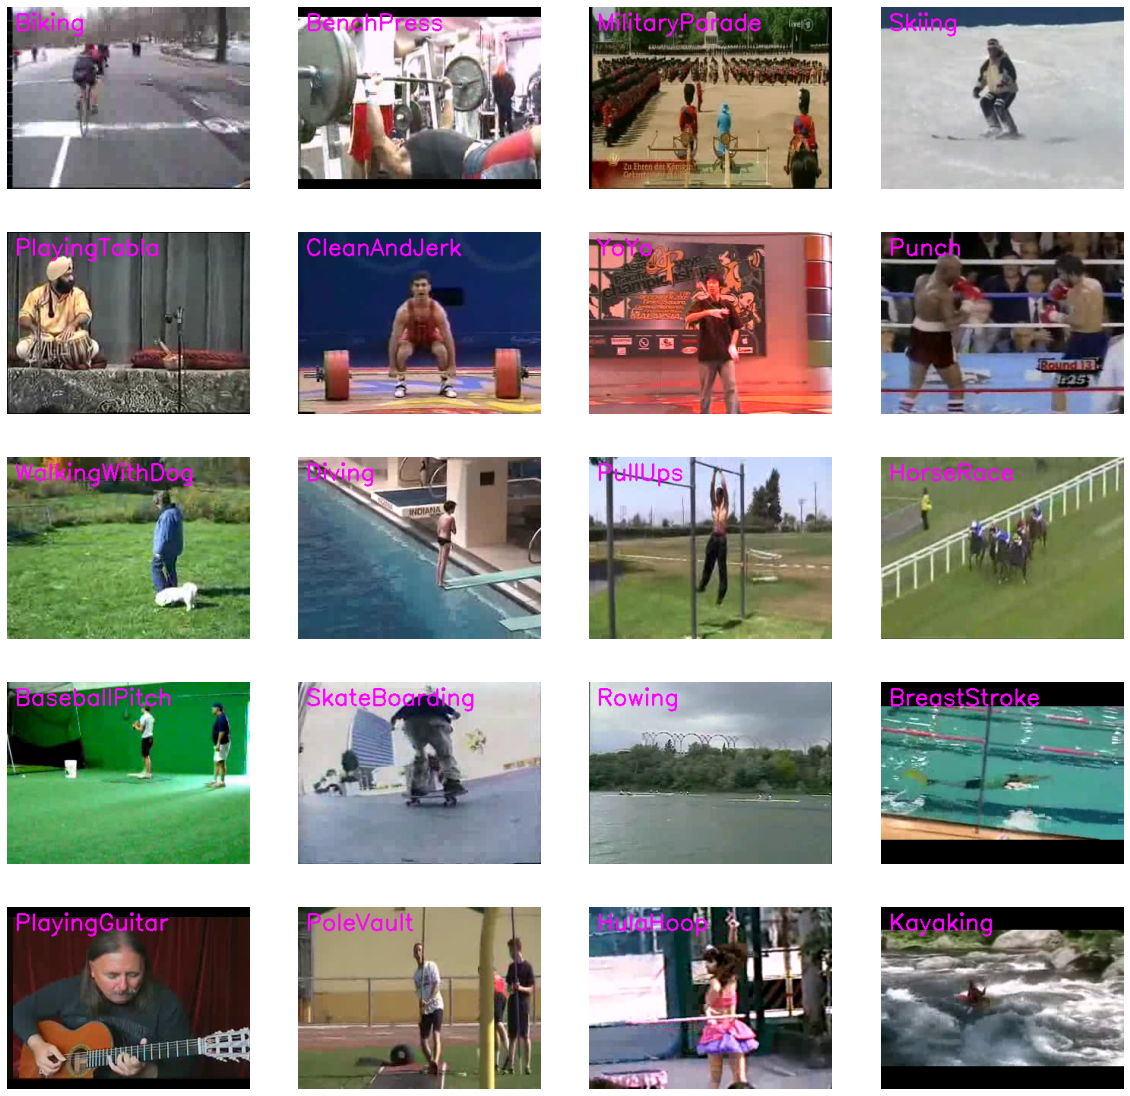

In [5]:
plt.figure(figsize=(20,20))

all_classes_names = os.listdir('UCF50')

random_range = random.sample(range(len(all_classes_names)),20)

for counter, random_index in enumerate(random_range,1) :
  selected_class_name = all_classes_names[random_index]

  video_files_names_list = os.listdir(f'UCF50/{selected_class_name}')

  selected_video_file_name = random.choice(video_files_names_list)

  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')

  _, bgr_frame = video_reader.read()

  video_reader.release()

  rgb_frame = cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)

  cv2.putText(rgb_frame, selected_class_name,(10,30),cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,255),2)
  plt.subplot(5,4,counter)
  plt.imshow(rgb_frame)
  plt.axis('off')

In [3]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64,64

SEQUENCE_LENGTH = 20

DATASET_DIR = "UCF50"

CLASSES_LIST = ["WalkingWithDog","TaiChi","Swing","HorseRace"]

In [4]:
def frame_extraction(video_path) :
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

  for frame_counter in range(SEQUENCE_LENGTH) :
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    ret, frame  = video_reader.read()

    if not ret :
      break 
    resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame = resized_frame/255
    frames_list.append(normalized_frame)
  video_reader.release()

  return frames_list

In [5]:
def create_dataset() :
  features = []
  labels = []
  video_files_paths = []

  for class_index, class_name in enumerate(CLASSES_LIST) :
    print(f"Extracting data of class : {class_name}")

    files_list = os.listdir(os.path.join(DATASET_DIR,class_name))

    for file_name in files_list :
      video_file_path = os.path.join(DATASET_DIR,class_name,file_name)

      frames = frame_extraction(video_file_path)

      if len(frames) == SEQUENCE_LENGTH :
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)
  
  
  features = np.asarray(features)
  labels = np.array(labels)

  return features, labels, video_files_paths
   

In [9]:
features, labels, video_files_paths = create_dataset()

Extracting data of class : WalkingWithDog
Extracting data of class : TaiChi
Extracting data of class : Swing
Extracting data of class : HorseRace


In [10]:
features.dtype

dtype('float64')

In [11]:
one_hot_encoded_labels = to_categorical(labels)

In [12]:
feature_train, feature_test, labels_train, labels_test = train_test_split(features,one_hot_encoded_labels,test_size=0.25,shuffle=True,random_state=seed_constant)

In [13]:
len(feature_train)

365

In [14]:
def create_convLSTM_model() :
  model = Sequential()

  model.add(ConvLSTM2D(filters=4,kernel_size=(3,3),activation='tanh',data_format="channels_last",
                       recurrent_dropout=0.2,return_sequences=True, input_shape=(SEQUENCE_LENGTH,
                                                                                 IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=8,kernel_size=(3,3),activation='tanh',data_format='channels_last',
                       recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=14,kernel_size=(3,3),activation='tanh',data_format='channels_last',
                       recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=16,kernel_size=(3,3),activation='tanh',data_format='channels_last',
                       recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))

  model.add(Flatten())

  model.add(Dense(len(CLASSES_LIST),activation="softmax"))

  model.summary()

  return model

In [15]:
model = create_convLSTM_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

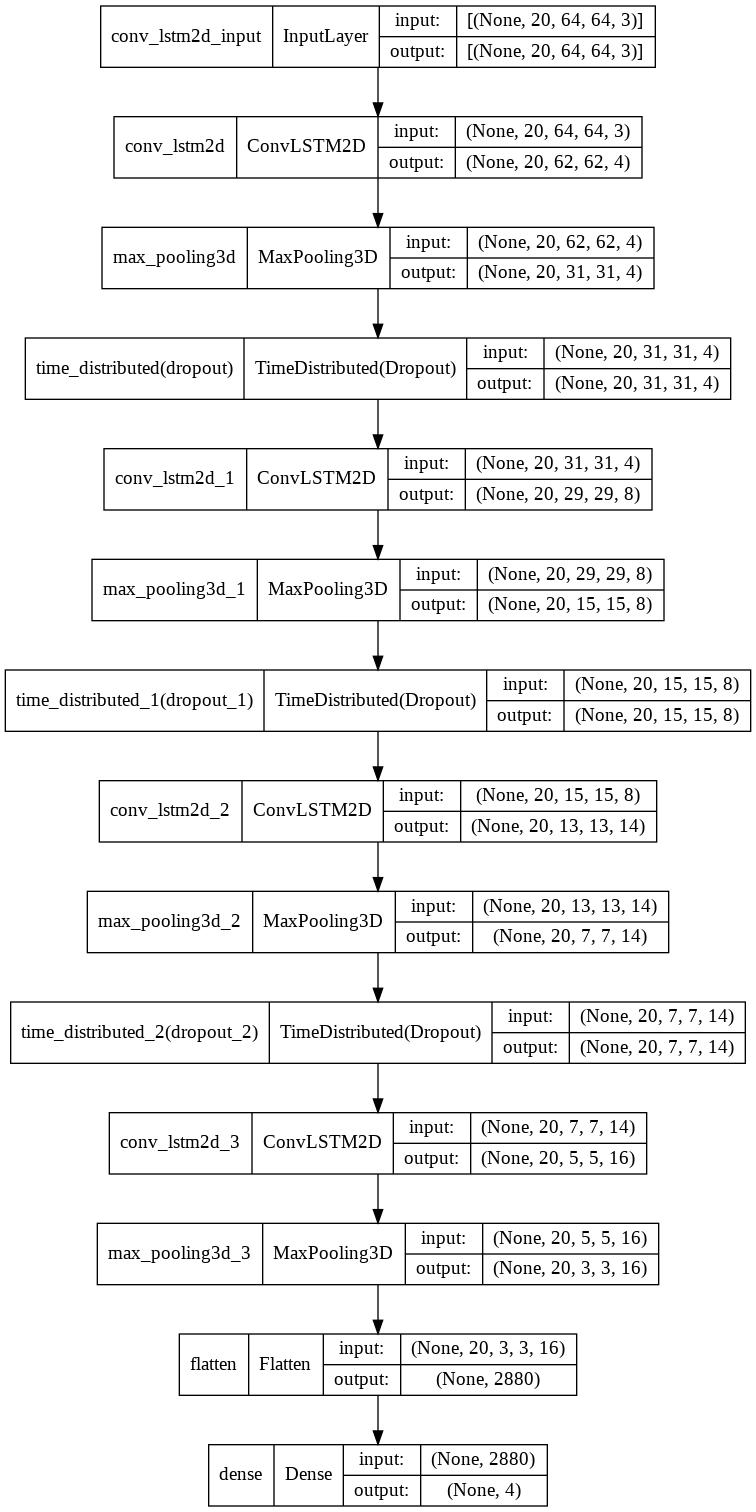

In [16]:
plot_model(model,to_file = 'model_plot.jpeg',show_shapes = True, show_layer_names = True)

In [ ]:
!mkdir logs
log_dir = 'Logs/'
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
early_stopping_callback = EarlyStopping(monitor= 'val_loss',patience=10,mode='min',restore_best_weights=True)

model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])

model_training_history = model.fit(x=feature_train, y=labels_train, epochs=50, batch_size=4,
                                   shuffle = True, validation_split = 0.2, 
                                   callbacks = [early_stopping_callback,tb_callback])

In [ ]:
model_evaluate_history = model.evaluate(feature_test,labels_test)

In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluate_history

date_time_format = "%Y_%m_%d_%H_%M_%S%"
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name =   "VideoClassification.h5"
model.save(model_file_name)

In [6]:
def plot_metric(model_training_history,metric_name_1, metric_name_2,plot_name) :
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  plt.title(str(plot_name))
  plt.legend()

In [ ]:
plot_metric(model_training_history,'loss','val_loss','Total loss vs  Total validation loss')

In [ ]:
plot_metric(model_training_history, 'accuracy','val_accuracy','Total accuracy vs Total validation accuracy')

In [ ]:
# Paper : Logn term Recurrent Convolutional Networks for Visual Recognition and Description 

In [17]:
def create_LRCN_model() :
  model = Sequential()
  
  model.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation ='relu'),
                             input_shape = (SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation ='relu')))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation ='relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation ='relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  # model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))
  
  model.add(LSTM(32))
  
  model.add(Dense(len(CLASSES_LIST),activation='softmax'))

  model.summary()

  return model

In [18]:
LRCN_model = create_LRCN_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

In [19]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss',patience=15,mode = 'min',restore_best_weights=True)
LRCN_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

LRCN_model_training_history = LRCN_model.fit(x = feature_train,y=labels_train,epochs=70,batch_size=4,shuffle=True,
                                             validation_split=0.2,callbacks = [early_stopping_callback])

Epoch 1/70
73/73 [==============================] - 21s 246ms/step - loss: 1.3997 - accuracy: 0.2671 - val_loss: 1.3607 - val_accuracy: 0.3562
Epoch 2/70
73/73 [==============================] - 14s 188ms/step - loss: 1.3674 - accuracy: 0.3322 - val_loss: 1.3198 - val_accuracy: 0.3699
Epoch 3/70
73/73 [==============================] - 14s 186ms/step - loss: 1.3000 - accuracy: 0.4418 - val_loss: 1.2526 - val_accuracy: 0.4521
Epoch 4/70
73/73 [==============================] - 14s 188ms/step - loss: 1.1957 - accuracy: 0.4658 - val_loss: 1.1315 - val_accuracy: 0.4658
Epoch 5/70
73/73 [==============================] - 14s 187ms/step - loss: 1.0563 - accuracy: 0.5719 - val_loss: 1.1010 - val_accuracy: 0.5205
Epoch 6/70
73/73 [==============================] - 14s 187ms/step - loss: 1.0277 - accuracy: 0.6096 - val_loss: 1.0531 - val_accuracy: 0.6027
Epoch 7/70
73/73 [==============================] - 14s 186ms/step - loss: 0.8336 - accuracy: 0.6952 - val_loss: 0.9878 - val_accuracy: 0.6027

In [20]:
LRCN_model_evaluate_history = LRCN_model.evaluate(feature_test, labels_test)

4/4 [==============================] - 2s 435ms/step - loss: 0.3498 - accuracy: 0.8852


In [22]:
LRCN_model_evaluation_loss, LRCN_model_evaluation_accuracy = LRCN_model_evaluate_history

LRCN_date_time_format = "%Y_%m_%d_%H_%M_%S%"
LRCN_current_date_time_dt = dt.datetime.now()
LRCN_current_date_time_string = dt.datetime.strftime(LRCN_current_date_time_dt, LRCN_date_time_format)

LRCN_model_file_name =   "LRCN_VideoClassification.h5"
LRCN_model.save(LRCN_model_file_name)

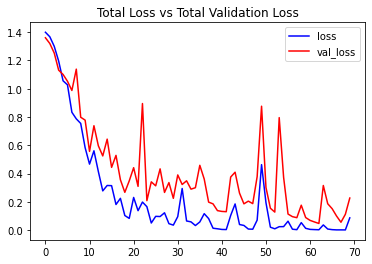

In [26]:
plot_metric(LRCN_model_training_history,'loss','val_loss','Total Loss vs Total Validation Loss')

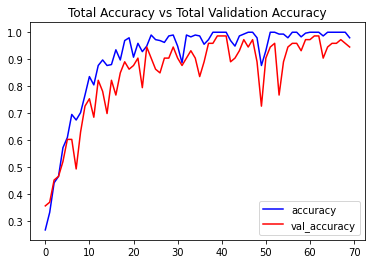

In [27]:
plot_metric(LRCN_model_training_history,'accuracy','val_accuracy',"Total Accuracy vs Total Validation Accuracy")

In [7]:
LRCN_model = tf.keras.models.load_model('LRCN_VideoClassification.h5')

In [47]:
def download_youtube_videos(youtube_video_url, output_directory) :
  video = pafy.new(youtube_video_url)
  title = 'demo'
  print(title)
  video_best = video.getbest()

  output_file_path = f"{output_directory}/{title}.mp4"

  video_best.download(filepath = output_file_path, quiet = True)

  return title



In [48]:
def predict_on_video(video_file_path,output_file_path,SEQUENCE_LENGTH):
  
  video_reader = cv2.VideoCapture(video_file_path)

  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M','P','4','V'),
                                 video_reader.get(cv2.CAP_PROP_FPS),(original_video_width,original_video_height))

  frames_queue = deque(maxlen = SEQUENCE_LENGTH)

  predicted_class_name = ''

  while video_reader.isOpened():
      ok, frame = video_reader.read()
      if not ok :
        break
      
      resized_frame = cv2.resize(frame, (IMAGE_WIDTH,IMAGE_HEIGHT))

      normalized_frame = resized_frame/255

      frames_queue.append(normalized_frame)

      if len(frames_queue) == SEQUENCE_LENGTH :
        predicted_labels_probs = LRCN_model.predict(np.expand_dims(frames_queue,axis=0))[0]
        predicted_label = np.argmax(predicted_labels_probs)

        predicted_class_name = CLASSES_LIST[predicted_label]

      cv2.putText(frame,predicted_class_name,(10,10),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

      video_writer.write(frame)

  video_reader.release()
  video_writer.release()


In [11]:
test_videos_directory = 'test_videos'

FileExistsError: ignored

In [ ]:
os.mkdir(test_videos_directory)

In [42]:
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE',test_videos_directory)

input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

test



In [54]:
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

In [55]:
predict_on_video(input_video_file_path,output_video_file_path,SEQUENCE_LENGTH)

KeyboardInterrupt: ignored

In [45]:
VideoFileClip(output_video_file_path,audio=False,target_resolution=(300,None)).ipython_display()

100%|██████████| 867/867 [00:03<00:00, 282.87it/s]


In [57]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH) :
  video_reader = cv2.VideoCapture(video_file_path)

  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  
  frames_list = []

  predicted_class_name = ''

  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

  for frame_counter in range(SEQUENCE_LENGTH) :
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    ret, frame  = video_reader.read()

    if not ret :
      break 
    resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame = resized_frame/255
    frames_list.append(normalized_frame)
  predicted_labels_probs = LRCN_model.predict(np.expand_dims(frames_list,axis=0))[0]
  predicted_label = np.argmax(predicted_labels_probs)

  predicted_class_name = CLASSES_LIST[predicted_label]

  print(f'Action Predicted : {predicted_class_name}\nConfidence: {predicted_labels_probs[predicted_label]}')

  video_reader.release()

In [59]:
video_title = download_youtube_videos('https://www.youtu.be/fc3w827kwyA',test_videos_directory)

input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'
predict_single_action(input_video_file_path,SEQUENCE_LENGTH)
# VideoFileClip(input_video_file_path,audio=False,target_resolution=(300,None)).ipython_display()

demo

Action Predicted : WalkingWithDog
Confidence: 0.917210578918457
